# Cross-Validation of `lm` model

Make a k-fold cross-validation using natural years. _Leave-one-(natural year)-out_

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(caret))
suppressMessages(library(BBmisc))

In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=12)

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [4]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Representative sample 

In [5]:
sites.lv <- c("es0118a", "es1438a") # Big cities (Madrid and Barcelona)",
sites.lv <- c(sites.lv, "es1580a", "es1340a") # small cities (Santander and Huelva)

## DataFrame Creation

In [6]:
# Create dataSet
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01")
                  ) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01"))

data.df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        mutate_if(is.factor, as.character) %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)

## PreProcess

In [7]:
deseason <- function(cl) {
    # Remove seasonal component of the additive time serie.
    #     This function is called below by an apply
    
    dcomp <- decompose(ts(cl, frequency = 365))

    cl - dcomp$seasonal
}

scale.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    split.df <- df[, -omit.cl]
    
    split.df <- scale(split.df)
    
    cbind(df[, omit.cl],
          apply(split.df, 2, function(cl) {cl + abs(min(cl))}))
}

range.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    split.df <- df[, -omit.cl]
    
    split.df <- normalize(split.df, method = "range", range = c(0, 1), margin = 1)
    
    cbind(df[, omit.cl],
          split.df
          #apply(split.df, 2, function(cl) {range(cl) + abs(min(cl))})
         )
}

In [8]:
std.filter <- function(df, numSTD, omit.cl) {
    split.df <- df[, -omit.cl]
    
    for (cl in names(split.df)) {
        mn <- mean(split.df[, cl], na.rm=TRUE)
        std <- sd(split.df[, cl], na.rm=TRUE)

        split.df[which(split.df[, cl] < mn-numSTD*std), cl] <- NaN
        split.df[which(split.df[, cl] > mn+numSTD*std), cl] <- NaN
    }
    
    cbind(df[, omit.cl], split.df)
}

## Cross-Validation

In [9]:
leave.one.year.out <- function(yr, data, omit.cl) { 
    # Do k-iteration of k-fold cv by pop yr data for test 
    #     and the rest for training
    # @params: omit.cl: columns to omit in the regression
    
    test <- which(year(data$date) == yr)
    train <- which(year(data$date) != yr)

    if(length(test) == 0) {
        return()
    } 
    if (length(train) == 0) {
        return()
    }
    
    model <- train(value ~., 
                   data=data[, -omit.cl], subset=train,
                   method="rf", ntree=50, 
                   allowParallel = TRUE
                  )

    y.th <- predict(model, newdata=data[test,])
    
    data.frame("bias"=mean(y.th) / mean(data[test,]$value),
               "var.ratio"=var(y.th) / var(data[test,]$value),
               "cor"=cor(y.th, data[test,]$value, method = "pearson")
              )
}

In [10]:
years <- 2013:2019

no.num.cl <- 1:3 # no numeric columns 
cv.df <- data.frame()

# Create one model for each pair of station-pollutant
for (st in sites.lv) {
    data.st <- data.df[data.df$site == st,]
    
    for (pll in levels(as.factor(data.st$variable))) {
        print(paste(st, pll))
        dat <- data.st[data.st$variable == pll, ]
        
        if (sum(!is.na(dat$date)) > (365*2)) {
            # if there is enough data (more than 2 years), deseasonalized
            ds.dat <- cbind(dat[, no.num.cl],
                         apply(dat[, -no.num.cl], 2, deseason))
        } else { next }
        
        ds.dat <- range.df(ds.dat, no.num.cl)# %>%
        ds.dat <- std.filter(ds.dat, 3, no.num.cl) %>%
                    drop_na()
        
        cv.row <- do.call(rbind, lapply(years, leave.one.year.out,
                                        ds.dat, no.num.cl))

        cv.df <- rbind(cv.df,
                       cbind(data.frame("variable"=pll,
                                        "site"=st),
                             rbind(colMeans(cv.row, na.rm=T)))
                       )
    }
}

[1] "es0118a no"
[1] "es0118a no2"
[1] "es0118a o3"
[1] "es0118a pm10"
[1] "es0118a pm2.5"
[1] "es1438a no"
[1] "es1438a no2"
[1] "es1438a o3"
[1] "es1580a no"
[1] "es1580a no2"
[1] "es1580a pm10"
[1] "es1340a no"
[1] "es1340a no2"
[1] "es1340a pm10"


In [11]:
cv.df

variable,site,bias,var.ratio,cor
<fct>,<fct>,<dbl>,<dbl>,<dbl>
no,es0118a,1.0044505,0.1947199,0.4315893
no2,es0118a,1.0129383,0.3906780,0.5346801
o3,es0118a,0.9976471,0.2490037,0.4779986
pm10,es0118a,1.0034828,0.3006581,0.5114250
pm2.5,es0118a,1.0087364,0.2756713,0.5145328
no,es1438a,1.0017505,0.2129611,0.3644256
no2,es1438a,1.0050312,0.2581181,0.4852672
no,es1580a,1.0029633,0.2681652,0.4272222
no2,es1580a,1.0188373,0.2135577,0.3679778


In [12]:
mean.cv.df <- cv.df %>%
                group_by(variable) %>%
                summarise(var.ratio=mean(var.ratio),
                          bias=mean(bias),
                          cor=mean(cor)
                         ) %>%
                print()

# A tibble: 5 x 4
  variable var.ratio  bias   cor
* <fct>        <dbl> <dbl> <dbl>
1 no           0.222 1.00  0.409
2 no2          0.316 1.01  0.508
3 o3           0.249 0.998 0.478
4 pm10         0.274 1.00  0.479
5 pm2.5        0.276 1.01  0.515


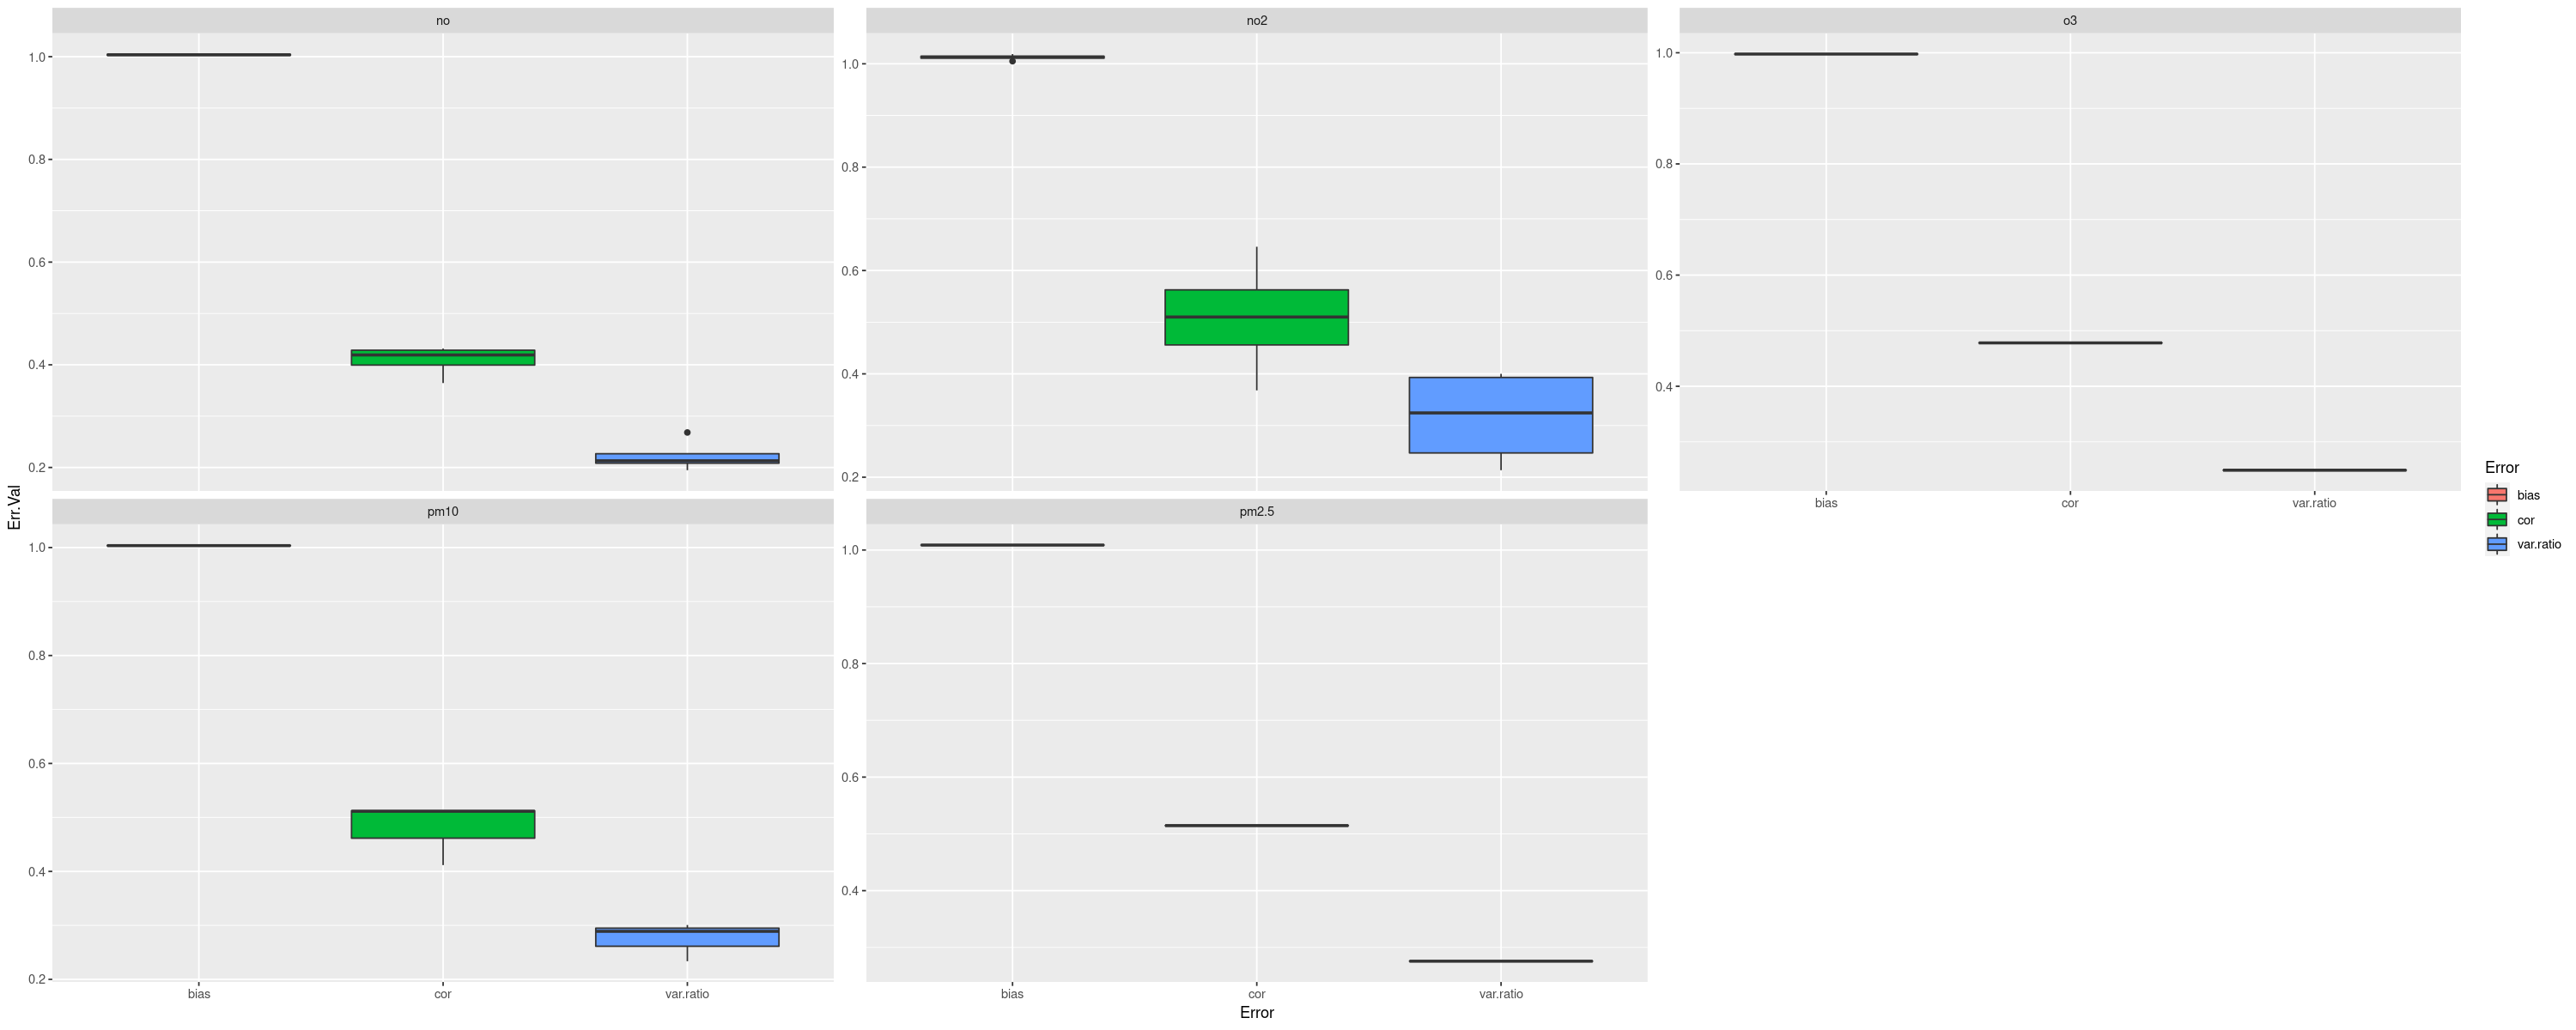

In [13]:
pivot.cv.df <- cv.df %>%
        pivot_longer(cols = c(3:ncol(cv.df)), 
                     names_to = "Error", values_to = "Err.Val")

ggplot(data=pivot.cv.df, aes(x=Error, y=Err.Val, fill=Error)) +
        geom_boxplot() + 
        facet_wrap(~variable, scales = "free_y")